# Малютин Павел, ИТПЗ РАН
 

In [1]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [2]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/DOUBLE_PREC_DD (2).csv', sep = ';') 
#my_cat = my_cat.loc[my_cat.YEAR < 1986]
my_cat = my_cat.loc[my_cat.latitude > 38.7751667]
my_cat = my_cat.loc[my_cat.latitude < 38.8081667]
my_cat = my_cat.loc[my_cat.longitude > -122.778]
my_cat = my_cat.loc[my_cat.longitude < -122.733]
my_cat = my_cat.reset_index(drop = True)
my_cat.mag = round(my_cat.mag, 1)  
my_cat.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,latitude,longitude,depth,EH1,EH2,AZ,EV,mag,ID
0,1984,1,5,22,28,2.400,38.78798,-122.77681,1.663,0.016,0.015,82,0.021,2.6,1109586
1,1984,1,5,23,9,52.920,38.78814,-122.77745,1.629,0.040,0.019,60,0.035,0.7,1109588
2,1984,1,7,14,24,9.790,38.78990,-122.77428,1.771,0.037,0.023,65,0.045,0.7,1109649
3,1984,1,8,2,7,38.960,38.78947,-122.77315,1.675,0.016,0.011,70,0.018,0.9,1109669
4,1984,1,9,2,12,4.417,38.78887,-122.77365,1.838,0.025,0.013,66,0.025,1.0,1109694


Text(0.5, 0.98, 'График повторяемости землетрясений')

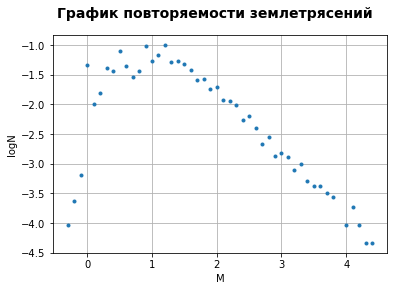

In [3]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [4]:
M_0 = float(input())
my_cat = my_cat.loc[my_cat['mag'] > M_0]
my_cat = my_cat.reset_index(drop = True)
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10))
# расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))
my_cat
N_tot = my_cat.shape
from pathlib import Path  
filepath = Path('./results/my_cat.csv')
my_cat.to_csv(filepath)

1.3
b-value is: 0.8652341705819793  ±  0.00587887750960517


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [5]:
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = (my_cat.latitude.to_numpy())
longitude = (my_cat.longitude.to_numpy())
depth = my_cat.depth.to_numpy()

In [24]:
la = np.array([longitude for i in range (N_tot[0])])
fi = np.array([latitude for i in range(N_tot[0])])
d =  np.array([depth for i in range(N_tot[0])])
PI_2 = np.array([[Pi2]*N_tot[0] for i in range(N_tot[0])])
col = PI_2 - np.arctan(FLAT*np.tan(RAD*fi))
dlon = RAD*np.transpose(la) - RAD*la
sin_col = np.multiply(np.sin(col),np.sin(np.transpose(col)))
cos_col = np.multiply(np.cos(col),np.cos(np.transpose(col)))
delr = np.arccos(np.multiply(sin_col,np.cos(dlon)) + cos_col)
colat = PI_2 - (0.5*(np.transpose(RAD*fi)+RAD*fi)) 
kek =  np.sqrt(np.power(np.multiply(6371.227*delr,(np.array([[1]*N_tot[0] for i in range(N_tot[0])]) + 0.00337853*(np.array([[1./3]*N_tot[0] for i in range(N_tot[0])]) -np.power(np.cos(colat),2)))),2) + np.power(np.transpose(d)-d,2))

kek = np.tril(kek, k=0)
#kek[kek == 0] = float('inf')

C:\Users\admin\AppData\Local\Temp\ipykernel_664\3105336408.py:9: RuntimeWarning: invalid value encountered in arccos
  delr = np.arccos(np.multiply(sin_col,np.cos(dlon)) + cos_col)


In [25]:
kek[kek == 0] = float('inf')

## Непосредственный расчёт фрактальной размерности

In [26]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.1,1.4,24) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):
    element_count = (kek < i).sum()
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0
    

100%|██████████████████████████████████████████| 24/24 [00:02<00:00, 10.81it/s]


In [15]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.1,1.4,24) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):
    for n in range(N_tot[0]):
        element_count += (kek[n] < i).sum()
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0

100%|██████████████████████████████████████████| 24/24 [00:04<00:00,  5.85it/s]


Text(0, 0.5, 'log(N/N_0)')

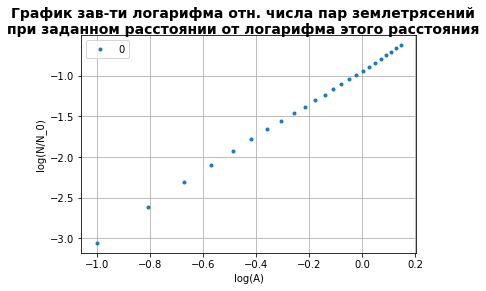

In [27]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

Fractal dimension is 2.0805150260713168


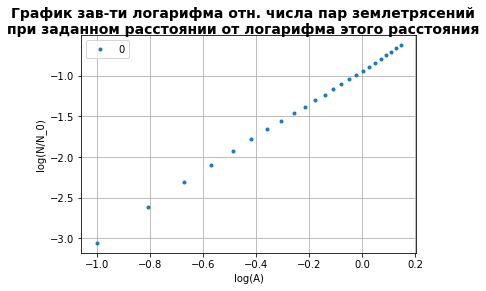

In [28]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()

plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model_d = LinearRegression()
linear_model_d.fit(X, Y)
d_f = linear_model_d.coef_[0][0] # фрактальная размерность
print('\033[1m' + 'Fractal dimension is', d_f)

# Функция близости

In [ ]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

In [ ]:
n_ = [[float('inf')] * N_tot[0] for i in range(N_tot[0])]
#T_ = [[0] * N_tot[0] for i in range(N_tot[0])]

In [ ]:
my_cat.SECOND = my_cat.SECOND.astype(int)
import datetime
year = my_cat.YEAR.to_numpy()
month = my_cat.MONTH.to_numpy()
day = my_cat.DAY.to_numpy()
hour = my_cat.HOUR.to_numpy()
minute = my_cat.MINUTE.to_numpy()
second = my_cat.SECOND.to_numpy()

### Функция для рассчёта времени между зт

In [ ]:
@jit 
def time_in_seconds (i, j):
    t_i = datetime.datetime(year[i], month[i], day[i], hour[i], minute[i], second[i])
    t_j = datetime.datetime(year[j], month[j], day[j], hour[j], minute[j], second[j])
    t_ij = (t_i - t_j).total_seconds()
    if t_ij == 0:
        return -0.1
    return -t_ij

In [ ]:
'''for i in tqdm(range(N_tot[0]-1,-1,-1)):
    for j in range(i,-1,-1):
        T_[i][j] = -time_in_seconds(i,j)
        T_[j][i] = T_[i][j]'''

In [ ]:
for i in tqdm(range(N_tot[0])):
    for j in range(i,N_tot[0]): #ВНИМАНИЕ - ХЗ ПОЧЕМУ ОТ И БЕРУ. ХОЧУ ПРОВЕРИТЬ
        if i == j:
            continue
        n_[j][i] = abs(time_in_seconds (i, j))*(array_of_dist[i][j]**d_f)*(10**((-b_value)*my_cat.mag[i]))
        #n_[j][i] = n_[i][j]
        

In [ ]:
np.save('n_', n_)


In [ ]:
N = [0] * N_tot[0]
D = [0] * N_tot[0]
for i in range(len(n_)):
    D[i] = round(math.log10((min(n_[i][:]))),1)
    N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [ ]:
resultate
from pathlib import Path  
filepath = Path('./results/nearest_dist_n_index.csv')
resultate.to_csv(filepath)

In [ ]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist.csv')
Dist_to_Nearest.to_csv(filepath)

In [ ]:
resultate

In [ ]:
part_cat = resultate.loc[resultate.index > 5922]
part_cat.Closest_neigh.mean()